# Sentiment Analysis of Amazon Food Reviews
This notebook implements custom machine learning models and a pre-trained model to predict sentiments of Amazon food reviews (as positive, neutral or negative review). Perfomances of the models are also compared to observe the best performing model on this dataset. Finally, prediction analysis of inaccurate predictions was done to understand why the model made such predictions. 

## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import string
import re
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from pycm import *   # a multi-class confusion matrix library
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word    
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, LSTM
from keras.optimizers import Adam
from statistics import mean
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
 # loading data
df = pd.read_csv('C:/Users/44744/Desktop/Notebooks/Reviews.csv', encoding='ISO-8859-1')
# df = pd.read_csv('C:/Users/tomna/Desktop/Desktop/Notebooks/Datasets/Amazon Fine Food Reviews/Reviews.csv', encoding='ISO-8859-1')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Profiling

In [3]:
# select columns of our interest
df = df[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Summary', 'Text']]
# rename the columns
df = df.rename(columns={'Score': 'Rating', 'Text': 'Review'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   HelpfulnessNumerator    568454 non-null  int64 
 1   HelpfulnessDenominator  568454 non-null  int64 
 2   Rating                  568454 non-null  int64 
 3   Summary                 568427 non-null  object
 4   Review                  568454 non-null  object
dtypes: int64(3), object(2)
memory usage: 21.7+ MB


In [4]:
# observing total counts and unique counts of reviews per rating
df.groupby('Rating')['Review'].describe().T

Rating,1,2,3,4,5
count,52268,29769,42640,80655,363122
unique,36280,20804,29772,56074,250745
top,"This review will make me sound really stupid, ...","I'm not a tea drinker, so I'll start with that...",My two traditional striped cats eat mostly dry...,Stash Chamomile Herbal Tea is tea bags with dr...,Diamond Almonds<br />Almonds are a good source...
freq,199,26,30,38,126


The total counts and unique counts of each rating group are different, indicating that there are duplicated reviews. We need to address the duplicates in the next section.

## Data Cleaning

In [5]:
# removing duplicated reviews observed above
original_rows = len(df['Review'])
df.drop_duplicates('Review', keep='first', inplace=True)  
new_rows = len(df['Review'])
print('Deleted number of duplicated reviews: ', original_rows - new_rows)

Deleted number of duplicated reviews:  174875


In [6]:
# confirming if the duplicates have been removed
df.groupby('Rating')['Review'].describe().T

Rating,1,2,3,4,5
count,36275,20792,29754,56042,250716
unique,36275,20792,29754,56042,250716
top,Product arrived labeled as Jumbo Salted Peanut...,If you are looking for the secret ingredient i...,This seems a little more wholesome than some o...,This is a confection that has been around a fe...,I have bought several of the Vitality canned d...
freq,1,1,1,1,1


In [7]:
# identify the rows whose HelpfulnessNumerator is greater than HelpfulnessDenominator as this should not be true
df.loc[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,HelpfulnessNumerator,HelpfulnessDenominator,Rating,Summary,Review
44736,3,2,4,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,3,1,5,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


Based on the defitions of HelpfulnessNumerator and HelpfulnessDenominator columns, the former should always be equal or less than the latter otherwise it is an error. Thus we need to remove rows meeting the second condition.

In [8]:
# removing the rows identified above
df = df.loc[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]

In [9]:
# reset index and select columns of our interest for the sentiment analysis task
df = df.reset_index(drop=True)
df = df[['Rating', 'Summary', 'Review']]
df.head()

,Rating,Summary,Review
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


## Exploratory Data Analysis

In [10]:
# viewing the first 5 reviews 
for review in df['Review'][:5]:
    print(review, '\n')

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. 

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo". 

This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch. 

If you are looking for the se

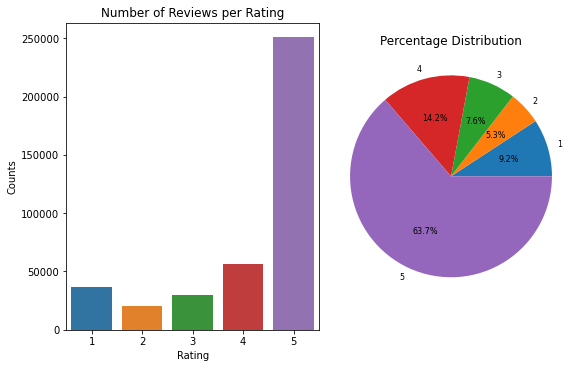

In [11]:
# plotting the distribution of reviews per each rating category

# plotting histogram
fig, axes = plt.subplots(1,2, figsize=(8,5),constrained_layout=True)
sns.countplot(ax=axes[0], x=df['Rating'])
axes[0].set_ylabel("Counts") 
axes[0].set_title('Number of Reviews per Rating')

# plotting pie chart
df['Rating'].value_counts().sort_index().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', fontsize=8)
axes[1].set_ylabel("")
axes[1].set_ylabel("")
axes[1].set_title('Percentage Distribution')
plt.show()

Our interest is to analyze the sentiments in three categories i.e positive, neutral and negative. We therefore categorize all reviews with rating 1-2 as negative, 3 as neutral and 4-5 as positive.

In [12]:
# mapping rating scores to sentiments positive, neutral and negative categories
convert_dict = {5: 'Positive', 4: 'Positive', 3: 'Neutral', 2: 'Negative', 1: 'Negative'}
df['Sentiment'] = df['Rating'].map(convert_dict)
# check if there is any null sentiment
print('Number of null sentiments: ', df['Sentiment'].isnull().sum())
df.head()

Number of null sentiments:  0


,Rating,Summary,Review,Sentiment
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,2,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,Great taffy,Great taffy at a great price. There was a wid...,Positive


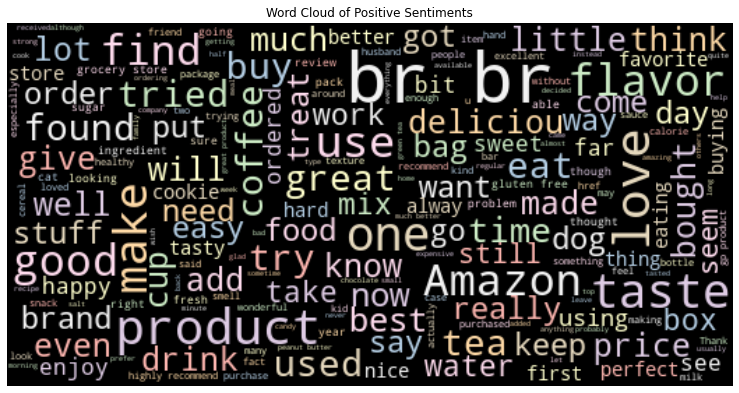

In [13]:
# plotting wordcloud of positive sentiments

# get a string of all positive sentiments as a string 
positive_sentiments = ' '.join(df['Review'][df['Sentiment'] == 'Positive'].dropna().astype(str))
positive_sentiment_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50, 
                        background_color="black", colormap='Pastel1').generate(positive_sentiments)
# plotting wordcloud of the texts
plt.figure(figsize=(13,9))
plt.imshow(positive_sentiment_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.title('Word Cloud of Positive Sentiments')
plt.show()

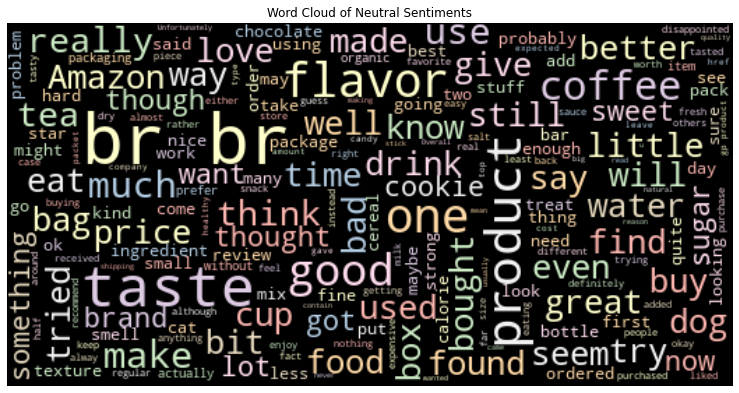

In [14]:
# plotting wordcloud of neutral sentiments

# get a string of all neutral sentiments as a string 
neutral_sentiments = ' '.join(df['Review'][df['Sentiment'] == 'Neutral'].dropna().astype(str))
neutral_sentiment_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50, 
                        background_color="black", colormap='Pastel1').generate(neutral_sentiments)
# plotting wordcloud of the texts
plt.figure(figsize=(13,9))
plt.imshow(neutral_sentiment_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.title('Word Cloud of Neutral Sentiments')
plt.show()

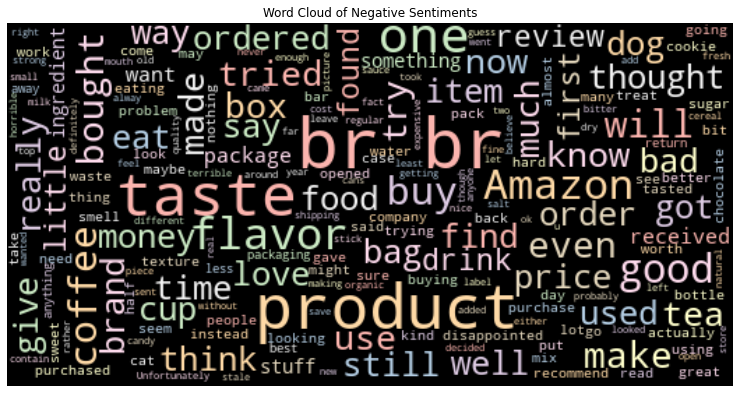

In [15]:
# plotting wordcloud of negative sentiments

# get a string of all negative sentiments as a string 
negative_sentiments = ' '.join(df['Review'][df['Sentiment'] == 'Negative'].dropna().astype(str))
negative_sentiment_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50, 
                        background_color="black", colormap='Pastel1').generate(negative_sentiments)
# plotting wordcloud of the texts
plt.figure(figsize=(13,9))
plt.imshow(negative_sentiment_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.title('Word Cloud of Negative Sentiments')
plt.show()

## Data Preprocessing

In [16]:
# select the reviews for evaluating the best model on the unseen reviews in the last section of the notebook
training_number_samples = 10000    # the number of reviews to pick for training and validating the models
unseen_number_samples = 51    # the number of unseen reviews for testing the model
df_positive_unseen = df.loc[df.Sentiment == 'Positive'].iloc[training_number_samples + 1 : training_number_samples + unseen_number_samples, :]   
df_neutral_unseen = df.loc[df.Sentiment == 'Neutral'].iloc[training_number_samples + 1 : training_number_samples + unseen_number_samples, :]     
df_negative_unseen = df.loc[df.Sentiment == 'Negative'].iloc[training_number_samples + 1 : training_number_samples + unseen_number_samples, :]  

df_unseen = pd.concat([df_positive_unseen, df_neutral_unseen, df_negative_unseen])  # combine the three mini dataframes
# shuffle and return all rows and reset the index while dropping the previous index
df_unseen = df_unseen.sample(frac = 1).reset_index(drop=True)
print('Distribution of unseen reviews per sentiment category:')
print(df_unseen['Sentiment'].value_counts().to_dict())

Distribution of unseen reviews per sentiment category:
{'Negative': 50, 'Positive': 50, 'Neutral': 50}


In [17]:
df_unseen.head()

,Rating,Summary,Review,Sentiment
0,1,Terrible coffee!,There is no way I would have known beforehand ...,Negative
1,5,Cavendar's Salt-Free,This is a must-have for Buffalo chicken wings....,Positive
2,5,fabulous,fabulous and very tasty item. I imeeditaley s...,Positive
3,1,Don't buy,Flavor lasts for only one minute for me.<br />...,Negative
4,5,Yum...,These arrived intact and not melted. I was ha...,Positive


In [18]:
# combining Summary and Review columns of the dataset that will be used to training and validation
df['Summary_Review'] = df['Summary'].astype(str) + ' ' + df['Review'].astype(str)
# print the resulting columns
df.columns.to_list()

['Rating', 'Summary', 'Review', 'Sentiment', 'Summary_Review']

In [19]:
# drop Summary and Review columns
df.drop(['Summary', 'Review'], axis=1, inplace=True)
df.head()

,Rating,Sentiment,Summary_Review
0,5,Positive,Good Quality Dog Food I have bought several of...
1,1,Negative,Not as Advertised Product arrived labeled as J...
2,4,Positive,"""Delight"" says it all This is a confection tha..."
3,2,Negative,Cough Medicine If you are looking for the secr...
4,5,Positive,Great taffy Great taffy at a great price. The...


In [20]:
print('Number of reviews per sentiment:')
print(df['Sentiment'].value_counts().to_dict())

Number of reviews per sentiment:
{'Positive': 306756, 'Negative': 57067, 'Neutral': 29754}


In [21]:
# reduce the number of samples to simplifies the training task and to balance data across the sentiment categories
# select the first N number of reviews of each review sentiment for training and validation
df_positive = df[df['Sentiment'] == 'Positive'].head(training_number_samples)   
df_neutral = df[df['Sentiment'] == 'Neutral'].head(training_number_samples)
df_negative = df[df['Sentiment'] == 'Negative'].head(training_number_samples)
df_ML = pd.concat([df_positive, df_neutral, df_negative])  # combine the three mini dataframes

# shuffle and return all rows and reset the index while dropping the previous index
df_ML = df_ML.sample(frac = 1).reset_index(drop=True)
number_classes = df_ML['Sentiment'].nunique() 
print('Distribution of reviews per sentiment category:')
print(df_ML['Sentiment'].value_counts().to_dict())

Distribution of reviews per sentiment category:
{'Negative': 10000, 'Positive': 10000, 'Neutral': 10000}


In [22]:
# pre-processing the texts by lowering case of the letter, removing stop words, special characters and punctuations, and converting words into their root words
df = df_ML
df['Summary_Review'] = df['Summary_Review'].apply(lambda x: " ".join(word.lower() for word in x.split())) # converting each word into lower case
stop = stopwords.words('english')
df['Summary_Review'] = df['Summary_Review'].apply(lambda x: " ".join(word for word in x.split() if word not in stop))  # removing stop words
df['Summary_Review'] = df['Summary_Review'].apply(lambda x: re.sub('<.*?>', '', x))  # removing html tags
df['Summary_Review'] = df['Summary_Review'].apply(lambda x: re.sub('[^a-zA-Z0–9\s]', '', x))  # removing encoded characters
df['Summary_Review'] = df['Summary_Review'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x))  # removing punctuations
df['Summary_Review'] = df['Summary_Review'].apply(lambda x: " ".join(word for word in x.split() if len(word) > 1)) # removing one character words
# performing stemming (remove -ing, -ly, etc) and lemmitization (converting words into their root words)
stemmer = PorterStemmer()
df['Summary_Review'] = df['Summary_Review'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
df['Summary_Review'] = df['Summary_Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [23]:
# tranforming the categorical target column to numerical one
map_sentiments = {'Positive': 2, 'Neutral': 1 , 'Negative': 0}
df['Sentiment'] = df['Sentiment'].map(map_sentiments)
df.head()

,Rating,Sentiment,Summary_Review
0,2,0,gluten free scd ye top pick arriv fresh fresh ...
1,5,2,fun daughter third child first son born sent o...
2,3,1,ok popcorn mildli spici popcorn smoke chili pe...
3,5,2,better expect sturdi review state flimsyi issu...
4,4,2,nice made work great rather small kitchen towe...


In [24]:
# splitting the data into train and test datasets by a ratio of 80:20. Stratify is used to ensure the same ratio of sentiment categories across the two datasets
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=123)
X_train, y_train = df_train['Summary_Review'], df_train['Sentiment']
X_test, y_test = df_test['Summary_Review'], df_test['Sentiment']
# taking values of the target column as numpy array
y_train = y_train.values
y_test = y_test.values
print('Size of train data:', len(X_train))
print('Size of test data:', len(X_test))

Size of train data: 24000
Size of test data: 6000


## Models Evaluation
### Classical Machine Learning Approach

In [25]:
# vectorizing the texts using the TFIDF method
vocab_size = 1100000  # the number should be equal or greater than the size of words in the text data
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', lowercase=False, stop_words=None, max_features=vocab_size)
tfidf_vect.fit(X_train)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)
print('Number of word vectors in train data: ', len(X_train_tfidf.data))
print('Vector list of train data: ', X_train_tfidf.data)
print('Number of word vectors in test data: ', len(X_test_tfidf.data))
print('Vector list of test data: ', X_test_tfidf.data)

Number of word vectors in train data:  900118
Vector list of train data:  [0.09205808 0.04810403 0.06480729 ... 0.19130726 0.1322993  0.13700626]
Number of word vectors in test data:  213031
Vector list of test data:  [0.22813281 0.13007476 0.16452138 ... 0.16606041 0.2890835  0.39485558]


In [26]:
# initializing a list to hold dataframes of results of all models
models_results_list = []  

In [27]:
# creating a function to evaluate the dataset using classical ML algorithms with a grid search CV technique
def model_tuning_evaluation(model_name, model, params, X_train, y_train, X_test):
    # model tuning
    grid_model = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', n_jobs=-1, cv=3)
    tuned_model = grid_model.fit(X_train, y_train)
    # model evaluation
    y_pred = tuned_model.predict(X_test)
    print(model_name, 'Evaluation Results',  ':')
    print('Best Parameters: ', tuned_model.best_params_)
    cm = ConfusionMatrix(y_test, y_pred)  # we use pycm multiclass library where both inputs should be in numpy array format
    accuracy_dict = cm.ACC  # returns a dictionary of accuracy for each class
    accuracy = mean(list(accuracy_dict.values()))  # get a mean of accuracies of all classes
    f1_dict = cm.F1
    f1 = mean(list(f1_dict.values()))  # get a mean of f1s of all classes
    AUC_dict = cm.AUC   
    AUC = mean(list(AUC_dict.values()))   # get a mean of AUCs of all classes
    print('Results -- Accuracy :', round(accuracy,3), ' | f1 :', round(f1,3),' | AUC :', round(AUC,3))
    return accuracy, f1, AUC, tuned_model

In [28]:
# creating a Logistic Regression model
model_name = 'Logistic Regression'
model = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 50)}
accuracy, f1, AUC, tuned_LR = model_tuning_evaluation(model_name, model, params, X_train_tfidf, y_train, X_test_tfidf)
# creating a dataframe of model's results and append them into the list of dataframes of results of all models
df_model_results = pd.DataFrame({"Accuracy":accuracy, "f1":f1, "AUC":AUC}, index=[model_name])
models_results_list.append(df_model_results)

Logistic Regression Evaluation Results :
Best Parameters:  {'C': 0.5689866029018293, 'penalty': 'l2'}
Results -- Accuracy : 0.823  | f1 : 0.734  | AUC : 0.801


In [29]:
# creating a Multinomial Naive Bayes model
model_name = 'Multinomial NB'
model = MultinomialNB()
params = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
accuracy, f1, AUC, tuned_NB = model_tuning_evaluation(model_name, model, params, X_train_tfidf, y_train, X_test_tfidf)
df_model_results = pd.DataFrame({"Accuracy":accuracy, "f1":f1, "AUC":AUC}, index=[model_name])
models_results_list.append(df_model_results)

Multinomial NB Evaluation Results :
Best Parameters:  {'alpha': 1}
Results -- Accuracy : 0.804  | f1 : 0.708  | AUC : 0.779


In [30]:

# creating an SVM model
model_name = 'SVM'
model = SVC()
params = {'kernel':['linear', 'rbf','poly'], 
              'C':[0.1, 1, 10, 50], 
              'gamma':[1,0.1,0.01,0.001],
              'degree':[1,2,3,4,5]
         }
accuracy, f1, AUC, tuned_SVM = model_tuning_evaluation(model_name, model, params, X_train_tfidf, y_train, X_test_tfidf)
df_model_results = pd.DataFrame({"Accuracy":accuracy, "f1":f1, "AUC":AUC}, index=[model_name])
models_results_list.append(df_model_results)

SVM Evaluation Results :
Best Parameters:  {'C': 1, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}
Results -- Accuracy : 0.825  | f1 : 0.738  | AUC : 0.803


In [31]:
# creating a LGBM model
model_name = 'LightGBM'
model = LGBMClassifier()
params = {'num_leaves': [15, 20, 30, 40, 50], 
             'min_child_samples': [20,50,100,200], 
             'subsample': [0.5, 0.7, 1.0], 
             'colsample_bytree': [0.6, 0.8, 1],
             'max_depth': [5, 10, 50, 100],
             'learning_rate': [0.01, 0.1, 0.5],
         }
accuracy, f1, AUC, tuned_LGBM = model_tuning_evaluation(model_name, model, params, X_train_tfidf, y_train, X_test_tfidf)
df_model_results = pd.DataFrame({"Accuracy":accuracy, "f1":f1, "AUC":AUC}, index=[model_name])
models_results_list.append(df_model_results)

LightGBM Evaluation Results :
Best Parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 50, 'min_child_samples': 20, 'num_leaves': 50, 'subsample': 0.5}
Results -- Accuracy : 0.814  | f1 : 0.72  | AUC : 0.791


### Deep Learning Approach

In [32]:
# text preprocessing for DL approach
# tokenize the messages and convert them into sequences of numbers
tokenizer = Tokenizer(num_words=vocab_size) # by default it lowers case the letters and removes punctuations
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
new_vocab_size = len(word_index) + 1
print('Total number of unique tokens: ', new_vocab_size)   # 1 should be added because the first index is reserved for padding and not assigned with a word

# get max length of sequences/words
def get_sequence_max_length(sequences):
    max_seq_length = 0
    for seq in sequences:
        seq_length = len(seq)
        if seq_length > max_seq_length:
            max_seq_length = seq_length
    return max_seq_length

max_seq_length = get_sequence_max_length(train_sequences)
print('Max sequence length of train data: ', max_seq_length)
max_seq_length = get_sequence_max_length(test_sequences)
print('Max sequence length of test data: ', max_seq_length)

Total number of unique tokens:  42325
Max sequence length of train data:  934
Max sequence length of test data:  796


In [33]:
# padding the sequences
max_seq_len = 1000  # the value should be equal or greater than the max sequence length obtained above
train_data = pad_sequences(train_sequences, maxlen=max_seq_len, padding='post', truncating='post') # adds zeros or truncates at the end of the sequence
test_data = pad_sequences(test_sequences, maxlen=max_seq_len, padding='post', truncating ='post')
print('Shape of train data: ', train_data.shape)
print('Shape of test data: ', test_data.shape)
print('Sample sequences:')
print(train_data[0:2:])   # checking sample sequences of the specified indexes

Shape of train data:  (24000, 1000)
Shape of test data:  (6000, 1000)
Sample sequences:
[[  58  991  637 ...    0    0    0]
 [  55  634 6084 ...    0    0    0]]


Next, we use Glove6B's vector representations of our corpus in order to capture contexts of the words, different from the bag of words methods such as TFIDF which do not.

In [34]:
# loading glove6B's vector representation of words in a dictionary, each word with 100 dimensions of vectors
from tqdm import tqdm  # for displaying activity progress bar
embeddings_index = {}
file = open('C:/Users/44744/Desktop/Notebooks/glove.6B/glove.6B.100d.txt', encoding='utf8')
for line in tqdm(file):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()
print('Found %s word vectors' % len(embeddings_index))

# creating a matrix of vectors of words from our corpus based on the vectors from Glove
embedding_matrix = np.zeros((len(word_index) + 1, 100))
#print(embedding_matrix)
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
         embedding_matrix[i] = embedding_vector

400000it [00:10, 38758.10it/s]


Found 400000 word vectors


100%|████████████████████████████████████████████████████████████████████████| 42324/42324 [00:00<00:00, 847980.94it/s]


In [35]:
# building FC DNN model
embedding_dim = 100  # number of output vector dimensions for each embedded word
def create_model(number_classes, neurons_1, neurons_2, dropout_rate, learn_rate, vocab_size, embedding_dim, embedding_matrix, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=new_vocab_size, output_dim=embedding_dim, input_length=max_seq_len, 
                        weights=[embedding_matrix], trainable=False))  # we use Glove's weights without retraining them
    model.add(GlobalAveragePooling1D())
    model.add(Dense(neurons_1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(number_classes, activation='softmax'))  # softmax is used for multiclass classification problem whereas sigmoid for binary classification
    optimizer = Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']) # we use categorical_crossentropy for multiclass classification problem instead of binary_crossentropy
    # 'categorical_crossentropy' works on one-hot encoded target, while 'sparse_categorical_crossentropy' works on integer target. Use binary_crossentropy for binary labels that are encoded as float32 scalars with values 0 or 1 
    return model

# selecting values of hyperparameters for tuning
param_grid = dict(neurons_1=[128, 256, 512],
                  neurons_2=[128, 256, 512],
                  dropout_rate=[0.1,0.2,0.3],
                  learn_rate=[0.001,0.01,0.1],
                  vocab_size=[new_vocab_size], 
                  embedding_dim=[embedding_dim],
                  embedding_matrix=[embedding_matrix],
                  max_seq_len=[max_seq_len],
                  number_classes=[number_classes]
                 )
model = KerasClassifier(build_fn=create_model, epochs=70, batch_size=10, verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, verbose=0, n_iter=5, n_jobs=-1)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0, n_jobs=-1)
stop_early = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]
tuned_FCDNN = grid.fit(train_data, y_train, validation_split=0.1, callbacks=stop_early, verbose=0)

# evaluate test data
y_pred = tuned_FCDNN.predict(test_data)
cm = ConfusionMatrix(y_test, y_pred)  
accuracy_dict = cm.ACC  
accuracy = mean(list(accuracy_dict.values()))  
f1_dict = cm.F1
f1 = mean(list(f1_dict.values()))
AUC_dict = cm.AUC   
AUC = mean(list(AUC_dict.values()))
print('FC DNN Evaluation Results:')
print('Best parameters: ', tuned_FCDNN.best_params_)
model_name = 'FC-DNN'
print()
print('Results -- Accuracy :', round(accuracy,3), ' | f1 :', round(f1,3),' | AUC :', round(AUC,3))
df_model_results = pd.DataFrame({"Accuracy":accuracy, "f1":f1, "AUC":AUC}, index=[model_name])
models_results_list.append(df_model_results)

188/188 [==============================] - 1s 6ms/step
FC DNN Evaluation Results:
Best parameters:  {'vocab_size': 42325, 'number_classes': 3, 'neurons_2': 256, 'neurons_1': 512, 'max_seq_len': 1000, 'learn_rate': 0.001, 'embedding_matrix': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]), 'embedding_dim': 100, 'dropout_rate': 0.3}

Results -- Accuracy : 0.732  | f1 : 0.587  | AUC : 0.699


In [36]:
# building 1D CNN model
def create_model(number_classes, num_filters, kernel_size, dropout_rate, learn_rate, vocab_size, embedding_dim, embedding_matrix, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=new_vocab_size, output_dim=embedding_dim, input_length=max_seq_len, 
                        weights=[embedding_matrix], trainable=False))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(number_classes, activation='softmax'))
    optimizer = Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# selecting values of hyperparameters for tuning
param_grid = dict(num_filters=[128, 256, 512],
                  kernel_size=[2, 3, 5, 7],
                  dropout_rate=[0.1,0.2,0.3],
                  learn_rate=[0.001,0.01,0.1],
                  vocab_size=[new_vocab_size], 
                  embedding_dim=[embedding_dim],
                  embedding_matrix=[embedding_matrix],
                  max_seq_len=[max_seq_len],
                  number_classes=[number_classes])
model = KerasClassifier(build_fn=create_model, epochs=70, batch_size=10, verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, verbose=0, n_iter=5, n_jobs=-1)
stop_early = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]
tuned_CNN = grid.fit(train_data, y_train, validation_split=0.1, callbacks=stop_early, verbose=0)

# evaluate test data
y_pred = tuned_CNN.predict(test_data)
cm = ConfusionMatrix(y_test, y_pred) 
accuracy_dict = cm.ACC 
accuracy = mean(list(accuracy_dict.values()))  
f1_dict = cm.F1
f1 = mean(list(f1_dict.values()))
AUC_dict = cm.AUC   
AUC = mean(list(AUC_dict.values()))
print('1D CNN Evaluation Results:')
print('Best parameters: ', tuned_CNN.best_params_)
model_name = 'CNN'
print()
print('Results -- Accuracy :', round(accuracy,3), ' | f1 :', round(f1,3),' | AUC :', round(AUC,3))
df_model_results = pd.DataFrame({"Accuracy":accuracy, "f1":f1, "AUC":AUC}, index=[model_name])
models_results_list.append(df_model_results)

188/188 [==============================] - 9s 47ms/step
1D CNN Evaluation Results:
Best parameters:  {'vocab_size': 42325, 'number_classes': 3, 'num_filters': 256, 'max_seq_len': 1000, 'learn_rate': 0.001, 'kernel_size': 3, 'embedding_matrix': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]), 'embedding_dim': 100, 'dropout_rate': 0.2}

Results -- Accuracy : 0.728  | f1 : 0.59  | AUC : 0.694


In [37]:
# comparing results of all ML and DL models
df_results = pd.concat(models_results_list, axis=0)  # appending dataframes row-wise
df_results.sort_values(['Accuracy','f1'], ascending=[False, False])
df_results

,Accuracy,f1,AUC
Logistic Regression,0.823333,0.734067,0.801250
Multinomial NB,0.803556,0.708034,0.779000
SVM,0.825111,0.738043,0.803250
LightGBM,0.813889,0.719965,0.790625
FC-DNN,0.732000,0.586939,0.698500
CNN,0.728333,0.589939,0.694375


In [38]:
# selecting the best performing model
best_model_name = df_results['Accuracy'].idxmax()  # return index value of the row with the maximum value of the specified column
print('Best model: ', best_model_name)

if best_model_name == 'Logistic Regression':
    best_model = tuned_LR
    type = 'Classic ML'
if best_model_name == 'Multinomial NB':
    best_model = tuned_NB
    type = 'Classic ML'
if best_model_name == 'SVM':
    best_model = tuned_SVM
    type = 'Classic ML'
if best_model_name == 'lightGBM':
    best_model = tuned_LGBM
    type = 'Classic ML'
if best_model_name == 'FC-DNN':
    best_model = tuned_FCDNN
    type = 'Deep ML'
if best_model_name == 'CNN':
    best_model = tuned_CNN
    type = 'Deep ML'

Best model:  SVM


#### Evaluating the Best ML Model on Unseen Data

In [39]:
# recall the unseen data
sentiment = df_unseen['Sentiment'].to_list()
reviews = df_unseen['Review'].to_list()
print(reviews[:3])
print()
print(sentiment[:3])

["There is no way I would have known beforehand exactly how Greek coffee tasted.  I went on the recommendation of an article citing it's medicinal qualities. I'm sorry but this was the worst tasting coffee I've EVER had! The seller was quick and had a good price but again, I DO NOT RECOMMEND THIS COFFEE!", "This is a must-have for Buffalo chicken wings. Most of the seasonings on the market have salt as the first ingredient. If not, no taste. Cavendar's is a staple in our pantry.", 'fabulous and very tasty item.  I imeeditaley stuffed a dozen with chopped lamb and rice and seasonings.  let them sit in a pickling brine over night...<br />absolutely fantastic...<br />yummu']

['Negative', 'Positive', 'Positive']


In [40]:
if type == 'Classic ML' :
    # converting reviews into tfidf vectors
    reviews_tfidf = tfidf_vect.transform(reviews)
    predictions = best_model.predict(reviews_tfidf)  # results returned as numpy array
if type == 'Deep ML':
    # tokenizing and padding the reviews to be predicted
    reviews_seq = tokenizer.texts_to_sequences(reviews) # using the same tokenizer used for training the model to attain consistent mapping
    padded_reviews = pad_sequences(reviews_seq, maxlen=max_seq_length, padding='post', truncating='post')
    predictions = best_model.predict(padded_reviews)

In [41]:
predictions

array([1, 0, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0,
       1, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 2, 0, 1, 0,
       2, 1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 1,
       2, 1, 1, 1, 0, 0, 0, 1, 2, 0, 2, 1, 2, 2, 0, 1, 1, 0, 2, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 1, 1, 0], dtype=int64)

In [42]:
# creating a dataframe of true and predicted labels
df_pred = pd.DataFrame({'Review':reviews, 'Sentiment':sentiment, 'Predicted_Sentiment':predictions})  

In [43]:
df_pred.head()

,Review,Sentiment,Predicted_Sentiment
0,There is no way I would have known beforehand ...,Negative,1
1,This is a must-have for Buffalo chicken wings....,Positive,0
2,fabulous and very tasty item. I imeeditaley s...,Positive,0
3,Flavor lasts for only one minute for me.<br />...,Negative,0
4,These arrived intact and not melted. I was ha...,Positive,1


In [44]:
# reverse the mapping of predictions to categorical values
reverse_map_sentiment = {2:'Positive', 1:'Neutral', 0:'Negative'}
df_pred['Predicted_Sentiment'] = df_pred['Predicted_Sentiment'].map(reverse_map_sentiment)

In [45]:
df_pred.head()

,Review,Sentiment,Predicted_Sentiment
0,There is no way I would have known beforehand ...,Negative,Neutral
1,This is a must-have for Buffalo chicken wings....,Positive,Negative
2,fabulous and very tasty item. I imeeditaley s...,Positive,Negative
3,Flavor lasts for only one minute for me.<br />...,Negative,Negative
4,These arrived intact and not melted. I was ha...,Positive,Neutral


In [46]:
# evaluating a prediction performance on the unseen sentiments - confusion matrix
def show_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(6,5))
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('Actual Sentiment')
    plt.xlabel('Predicted Sentiment')
    plt.title('Confusion Matrix - ML Prediction')
    plt.show() 

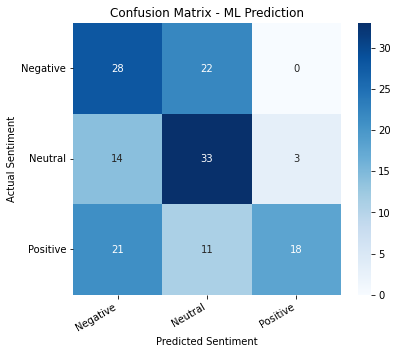

In [47]:
y_true = df_pred['Sentiment'].to_list()
y_pred = df_pred['Predicted_Sentiment'].to_list()
cm = confusion_matrix(y_true, y_pred)
class_names = ['Negative', 'Neutral', 'Positive']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [48]:
# evaluating a prediction performance on the unseen sentiments - classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    Negative       0.44      0.56      0.50        50
     Neutral       0.50      0.66      0.57        50
    Positive       0.86      0.36      0.51        50

    accuracy                           0.53       150
   macro avg       0.60      0.53      0.52       150
weighted avg       0.60      0.53      0.52       150



## Transfer Learning with Transformer (BERT)
Unlike the supervised learning performed above, here we use unsupervised approach with a pretained transformer  model which was trained on a large corpus of data. Transformers accounts for the words but also the context related to other words (both a word before and after the targeted word). Specifically, we use a bert-base-multilingual-uncased model which is fine tuned for sentiment analysis on product reviews in six languages, including English. It predicts the sentiment of the review as a number of stars (between 1 and 5). The aim is to compare its performance with the supervised methods implemented above

In [49]:
# instatiate the BERT model fine tuned for sentiment analysis
pre_trained_model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(pre_trained_model_name)
model = AutoModelForSequenceClassification.from_pretrained(pre_trained_model_name)

Since the model is pretrained, we only the need to test the unseen reviews we separated earlier. We first test the sampled review and see the result of the model

In [50]:
# pick a sample review
df = df_unseen
sample_review = df['Review'][0]
print(sample_review)

There is no way I would have known beforehand exactly how Greek coffee tasted.  I went on the recommendation of an article citing it's medicinal qualities. I'm sorry but this was the worst tasting coffee I've EVER had! The seller was quick and had a good price but again, I DO NOT RECOMMEND THIS COFFEE!


In [51]:
# generate tokens of the review
tokens = tokenizer.encode(sample_review, return_tensors='pt')  # returns the encoded review in pytorch tensor
print(tokens[0])  

tensor([  101, 10768, 10127, 10181, 12140,   151, 11008, 10574, 11197, 11364,
        31519, 56938, 12548, 15629, 37181, 44960, 10163,   119,   151, 13661,
        10125, 10103, 44909, 55667, 77393, 10108, 10144, 12877, 62784, 10197,
          112,   161, 63657, 15862, 14086,   119,   151,   112,   155, 72445,
        10502, 10372, 10140, 10103, 43060, 17439, 12305, 37181,   151,   112,
        10312, 15765, 10407,   106, 10103, 83815, 10140, 34307, 10110, 10407,
          143, 12050, 16993, 10502, 12590,   117,   151, 10154, 10497, 44909,
        55667, 10163, 10372, 37181,   106,   102])


In [52]:
# decode the tokens to see if we get back the original review
tokenizer.decode(tokens[0])

"[CLS] there is no way i would have known beforehand exactly how greek coffee tasted. i went on the recommendation of an article citing it's medicinal qualities. i'm sorry but this was the worst tasting coffee i've ever had! the seller was quick and had a good price but again, i do not recommend this coffee! [SEP]"

In [53]:
# return probabilites of the texts for a given sentiment rating (1 -5)
result = model(tokens).logits  
result

tensor([[ 4.3112,  2.8481,  0.0951, -2.9570, -3.4469]],
       grad_fn=<AddmmBackward0>)

In [54]:
 # returns a sentiment rating (from 1 to 5, 5 being the best) by converting the above probabilities
int(torch.argmax(result)) + 1 

1

The predicted rating is 1, meaning the review is negative. This matches with the sentiment of the reviewer who does not recommend the product.

#### Evaluating the BERT Model on Unseen Data

Now we find predicted sentiments of all unseen reviews in our dataset.

In [55]:
# find the max sequence length of all the reviews
token_lengths = []
for review in df.Review:
    tokens = tokenizer.encode(review, truncation=True, max_length=512)
    token_lengths.append(len(tokens))

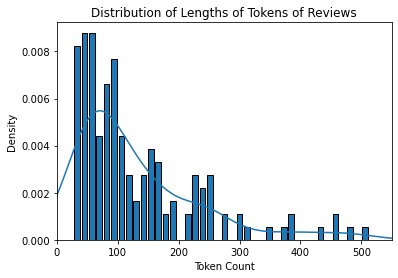

In [56]:
# plot the token lengths
plt.figure(figsize=(6,4))
sns.distplot(x=token_lengths, bins=40, hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0})
plt.xlim([0, 550])
plt.xlabel('Token Count')
plt.title('Distribution of Lengths of Tokens of Reviews')
plt.show()

Most of the reviews have token length up to 250 while few reaches just above 500. To be in safe side, we will use the max length for BERT which is 512.

In [57]:
# define a function to find a sentiment rating of any passed review
def get_sentiment_score(review):
    tokens = tokenizer.encode(
                              review, 
                              truncation=True, # truncate the sequence length if it exceeds the specified max length below
                              max_length=512,  # BERT and most tranformers have a max sequence length of 512 tokens per text/sentence
                              pad_to_max_length=True, # add extra characters to short tokens to maintain the same token length to all reviews
                              add_special_tokens=True,  # add '[CLS]' and '[SEP]'
                              return_tensors='pt'  # returns the tokens as pytorch tensors
                             )
    result = model(tokens).logits
    return int(torch.argmax(result)) + 1

In [58]:
# get predictions of sentiment ratings of all reviews
df['BERT_Rating'] = df['Review'].apply(lambda x: get_sentiment_score(x))   # get ratings of all reviews

# mapping rating scores to sentiments categories (positive, neutral and negative)
convert_dict = {5: 'Positive', 4: 'Positive', 3: 'Neutral', 2: 'Negative', 1: 'Negative'}
df['BERT_Sentiment'] = df['BERT_Rating'].map(convert_dict)
df.head()

,Rating,Summary,Review,Sentiment,BERT_Rating,BERT_Sentiment
0,1,Terrible coffee!,There is no way I would have known beforehand ...,Negative,2,Negative
1,5,Cavendar's Salt-Free,This is a must-have for Buffalo chicken wings....,Positive,3,Neutral
2,5,fabulous,fabulous and very tasty item. I imeeditaley s...,Positive,4,Positive
3,1,Don't buy,Flavor lasts for only one minute for me.<br />...,Negative,2,Negative
4,5,Yum...,These arrived intact and not melted. I was ha...,Positive,3,Neutral


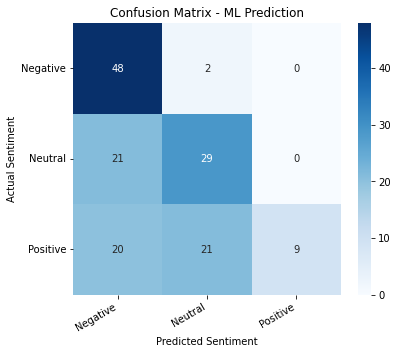

In [59]:
# evaluating performance on the unseen sentiments - confusion matrix
y_true = df['Sentiment'].to_list()
y_pred = df['BERT_Sentiment'].to_list()
cm = confusion_matrix(y_true, y_pred)
class_names = ['Negative', 'Neutral', 'Positive']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [60]:
# evaluating performance on the unseen sentiments - classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    Negative       0.54      0.96      0.69        50
     Neutral       0.56      0.58      0.57        50
    Positive       1.00      0.18      0.31        50

    accuracy                           0.57       150
   macro avg       0.70      0.57      0.52       150
weighted avg       0.70      0.57      0.52       150



It can be observed that BERT has outperformed our custom machine learning methods.

 ## Prediction Analysis
 Here, let's see why our best model (BERT) has made false predictions using some specific examples.

In [61]:
# add a column to make comparisons between actual and predicted sentiments
df['Comparison'] = np.where(df['Sentiment'] == df['BERT_Sentiment'], True, False)   # label True if predictions match else False
df.head()

,Rating,Summary,Review,Sentiment,BERT_Rating,BERT_Sentiment,Comparison
0,1,Terrible coffee!,There is no way I would have known beforehand ...,Negative,2,Negative,True
1,5,Cavendar's Salt-Free,This is a must-have for Buffalo chicken wings....,Positive,3,Neutral,False
2,5,fabulous,fabulous and very tasty item. I imeeditaley s...,Positive,4,Positive,True
3,1,Don't buy,Flavor lasts for only one minute for me.<br />...,Negative,2,Negative,True
4,5,Yum...,These arrived intact and not melted. I was ha...,Positive,3,Neutral,False


In [62]:
# re-ordering columns
df = df[['Summary', 'Review', 'Rating', 'Sentiment', 'BERT_Rating', 'BERT_Sentiment', 'Comparison']]
# find and print out only reviews whose sentiments which were wrongly predicted
df_false_pred = df[df['Comparison'] == False]
# reset index
df_false_pred.reset_index(drop=True, inplace=True)
df_false_pred[:15]

,Summary,Review,Rating,Sentiment,BERT_Rating,BERT_Sentiment,Comparison
0,Cavendar's Salt-Free,This is a must-have for Buffalo chicken wings....,5,Positive,3,Neutral,False
1,Yum...,These arrived intact and not melted. I was ha...,5,Positive,3,Neutral,False
2,My addiction,Light. Crispy. Chocolate! I had the hardest t...,5,Positive,2,Negative,False
3,Best chocolate ever!,This chocolate is the best thing ever - made m...,4,Positive,2,Negative,False
4,An Example of Truth in Advertising,"These things are definitely big, definitely ha...",3,Neutral,2,Negative,False
5,sesame confection with pistachios,Please see my other review for more details (v...,4,Positive,2,Negative,False
6,Very special treats,"Boy our dogs go crazy for these treats, I buy ...",5,Positive,3,Neutral,False
7,Breeder Recommended & Cavalier King Charles Pu...,The breeder started our puppy on a mix of this...,5,Positive,3,Neutral,False
8,"Sugar, sugar and more sugar!","Don't let words like ""chewy granola bar"" or ""7...",3,Neutral,2,Negative,False
9,great cordials,"These cordials are very hard to find, so I was...",5,Positive,2,Negative,False


In [66]:
# the 5th review from the list of reviews above
df_false_pred['Review'][4]

"These things are definitely big, definitely have peanuts and peanut butter, and they're chewy. But they're also rather boring. You REALLY have to like peanuts to be able to work your way through one. It feels like something's missing -- a little sweetness, a little salt -- not sure what it is, but something would help. I asked the techs on my production crew to test a couple. Bear in mind that they'll eat anything from a craft service table, but they also found them lacking in some essential ingredient.<br /><br />The bars also get a bit mushy to the point of being messy when warm.<br /><br />If you're a big fan of peanuts and peanut butter and that's all you want, then these bars are for you. If you need a little variety in your treats, then maybe go for something with a little chocolate or other added flavors.<br /><br />I'm sorry if I've hurt your feelings, Mr. Peanut. I've always been a big fan."

This is a neutral review but we can see why BERT has labelled it negative. The model relied more on the downside of the product addressed by the reviewer, that is lacking of flavor.

In [67]:
# the 6th review
df_false_pred['Review'][5]

'Please see my other review for more details (vanilla Halvah).<br /><br />This is a confection bar with fine-ground sesame seeds with pistachios mixed in.<br /><br />If you like sesame, and pistachio, you will probably like Halvah.'

This is a positive review but was predicted as negative. This is likely because the reviewer has suggested that the product can be more enjoyable to consumers who like other particular products and may not be enjoyable to all consumers.

In [68]:
# the 7th review
df_false_pred['Review'][6]

"Boy our dogs go crazy for these treats, I buy the regular sized ones and cut them into thirds, they are easy to cut and our dogs are small Yorkies so the third portion is perfect for a treat. They are good for their teeth too. We have one 12 year old and her teeth are perfect. They are one of our dogs favorite treats that we buy. Your dog will love the flavor and they are made in the USA. Can't beat that, just wish they were a bit cheaper."

This is a positive review but was predicted as neutral. This is likely because of the last sentence in which the reviewer has suggested that the product is a expensive and could have been cheaper.